# StaTexNet - Network Encoding Statistics for Textures

## Dependencies & Hyperparameters

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('/home/gridsan/ckoevesdi/.local/lib/python3.9/site-packages/')
from pytorch_metric_learning import losses

sys.path.append('/home/gridsan/ckoevesdi/PooledStatisticsMetamers/poolstatmetamer/')
import utils.statnetencoder as sne
import importlib

#!wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py

#sys.path.append(r'C:\Users\chris\Documents\MIT\Statistics_analysis_code\PyTorchSteerablePyramid')
sys.path.append('/home/gridsan/ckoevesdi/PyTorchSteerablePyramid/')
import steerable
import steerable.utils as utils
from steerable.SCFpyr_PyTorch import SCFpyr_PyTorch

torch.manual_seed(12)

#use GPU 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
#hyperparams
num_epochs = 40
batch_size = 20
crop_size = 128 #changed to 64 as fourcrop doesn't exist
num_stats = 50 
optimizer_type='adam'
#optimizer_type='sgd'
learning_rate = 0.001
num_crops = 5 #changed this to four

sparsity_penalty = 0 #0.001

#dataset location
#dtd_folder = '/gridsan/ckoevesdi/data/dtd_torch/dt/'
dtd_folder = '/home/gridsan/ckoevesdi/data/dtd_torch/dtd/dtd/'

## Define DataLoader

In [3]:
loading_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Slight brightness & contrast adjustment
    transforms.FiveCrop(size=crop_size), 
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # Changed PILToTensor to ToTensor as it's more standard
    transforms.ConvertImageDtype(torch.float32)
])

#use training set for now
dtd_dataset = torchvision.datasets.DTD(root='/home/gridsan/ckoevesdi/data/dtd_torch/', split='train', partition=10, 
                                       transform=loading_transforms, target_transform=None,
                                       download=False) #ah das datenset muss so aussehen wie es auf der website auch ist, deswegen kann man auch download false machen

sampler = data.RandomSampler(dtd_dataset)

dtd_dataloader = DataLoader(dtd_dataset, 
                            sampler=sampler,
                            batch_size=batch_size, 
                            shuffle=False)
#dtd_labels = tf

tensor2pil_transform = transforms.ToPILImage()

In [4]:
loading_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Slight brightness & contrast adjustment
    transforms.FiveCrop(size=crop_size), 
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # Changed PILToTensor to ToTensor as it's more standard
    transforms.ConvertImageDtype(torch.float32)
])

#use training set for now
dtd_dataset = torchvision.datasets.DTD(root='/home/gridsan/ckoevesdi/data/dtd_torch/', split='train', partition=1, 
                                       transform=loading_transforms, target_transform=None,
                                       download=False) #ah das datenset muss so aussehen wie es auf der website auch ist, deswegen kann man auch download false machen


dtd_dataloader = DataLoader(dtd_dataset, 
                            batch_size=batch_size, 
                            shuffle=False)
#dtd_labels = tf

tensor2pil_transform = transforms.ToPILImage()

## Test Dataloader

tensor([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,
         3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,
         7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10,
        10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14,
        14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
        18, 18, 18, 18, 18, 19, 19, 19, 19, 19])


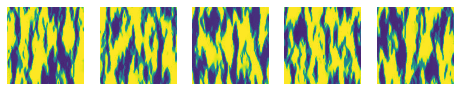

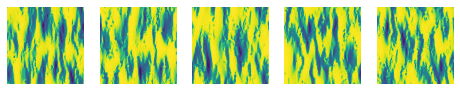

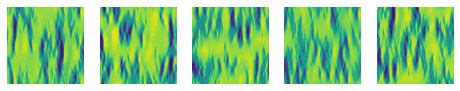

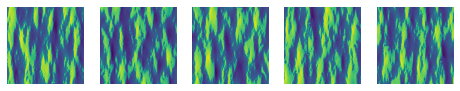

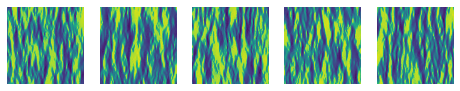

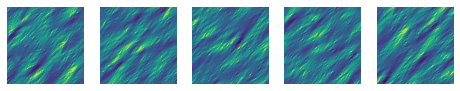

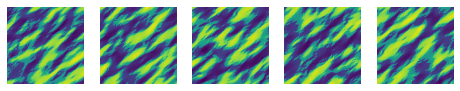

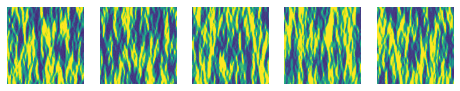

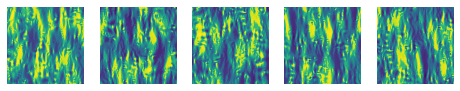

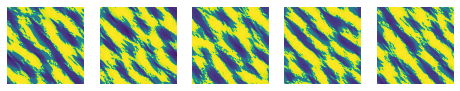

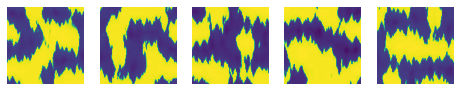

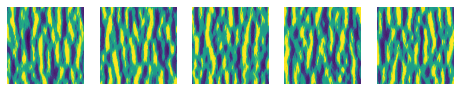

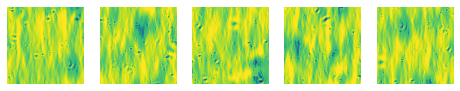

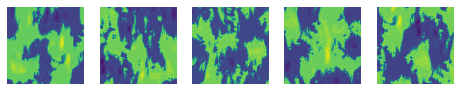

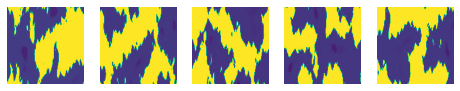

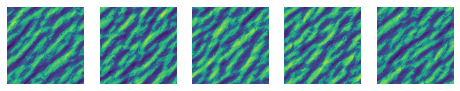

tensor([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,
         3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,
         7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10,
        10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14,
        14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
        18, 18, 18, 18, 18, 19, 19, 19, 19, 19])


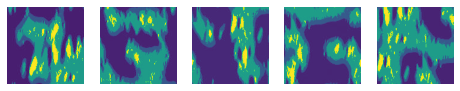

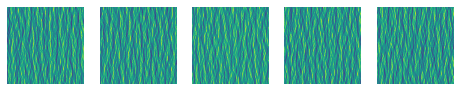

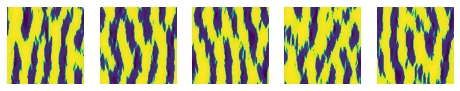

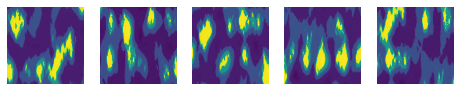

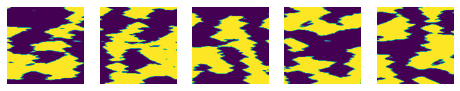

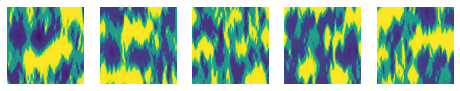

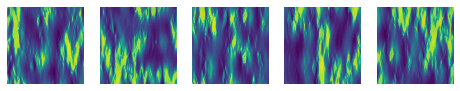

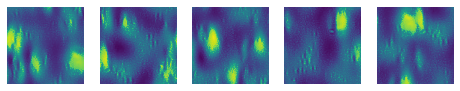

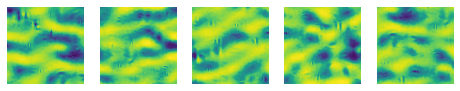

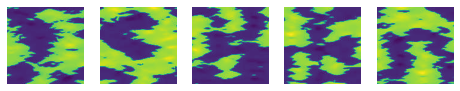

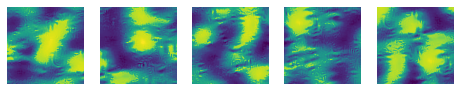

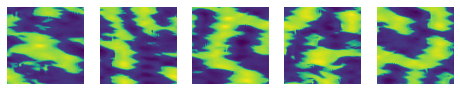

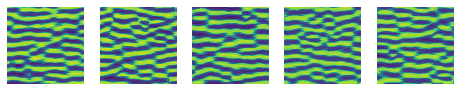

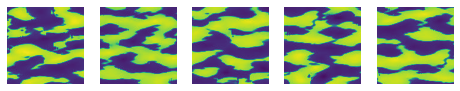

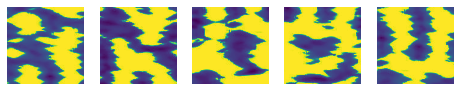

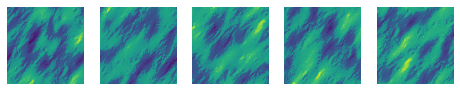

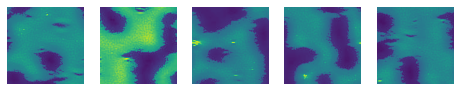

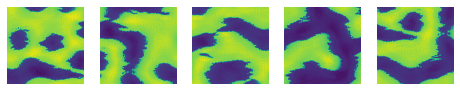

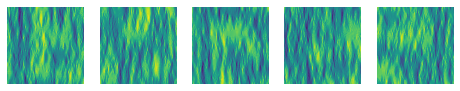

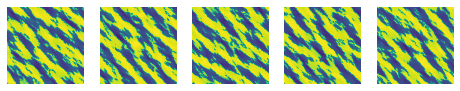

In [5]:
if(True):    
    for n, texture_batch in enumerate(dtd_dataloader):
         #grab texture batch and generate matching labels
         output = texture_batch[0].to(device)
         output = torch.flatten(output, start_dim=0, end_dim=1)
         texture_labels = torch.repeat_interleave(torch.arange(batch_size),num_crops)
         #apply random permutation
         print(texture_labels)
         #loop through batch and plot images
         for j in range(batch_size):
             plt.figure(figsize=(8,4))
             for i in range(num_crops):
                 plt.subplot(2,5,i+1)
                 plt.imshow(tensor2pil_transform(output[i+j*num_crops,:,:,:]))
                 plt.axis('off')
             plt.show()
         if(n==1):
             break;
    
#tensor2pil_transform(output[4,0,:,:,:])

## Define Model & Optimizer

In [6]:
importlib.reload(sne)
statnet_model = sne.StatNetEncoder(img_size=(crop_size,crop_size),
                                   batch_size=batch_size,
                                   num_stats=num_stats,
                                   device=device)
statnet_model.to(device)
num_total_epochs = 0
stat_labels = statnet_model.getsstatlabels(device)
#optimizer
if(optimizer_type=='sgd'):
    optimizer = torch.optim.SGD(statnet_model.parameters(), lr=learning_rate)#, momentum=learning_momentum)
elif(optimizer_type=='adam'):
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adagrad'):
    optimizer = torch.optim.Adagrad(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adadelta'):
    optimizer = torch.optim.Adadelta(statnet_model.parameters(), lr=learning_rate)
else:
    print('No Optimizer Specified! Adam is default!')
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)

Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Run Training

In [7]:
loss_func_contrastive = losses.GeneralizedLiftedStructureLoss()
training_loss = []
training_representation_loss = []
training_sparsity_loss = []
num_total_epochs = 0
#[s for s in stat_labels] #print all stats with details

In [8]:
print('Total Stats:',len(stat_labels))

summation=0

for stat in ['edge_mean','edge_variance','edge_stop','edge_correlation','phase_correlation','mean','variance','bandpass_variance','skew','kurtosis']:

    num_this_stat = len([s for s in stat_labels if s.weight_category==stat])

    print(f'{stat} Stat:',num_this_stat)

    summation += num_this_stat

print('Stats Sum to:',summation)

Total Stats: 150
edge_mean Stat: 16
edge_variance Stat: 16
edge_stop Stat: 16
edge_correlation Stat: 36
phase_correlation Stat: 48
mean Stat: 1
variance Stat: 6
bandpass_variance Stat: 1
skew Stat: 5
kurtosis Stat: 5
Stats Sum to: 150


In [9]:
importlib.reload(sne)
loss_func_contrastive = losses.GeneralizedLiftedStructureLoss()
training_loss = []
training_representation_loss = []
training_entropy_loss = []
training_multistat_loss = []
training_sparsity_loss = []
num_total_epochs = 0
weights = []

one_columns = torch.ones((batch_size*num_crops,num_stats), dtype=torch.float32,requires_grad=True).to(device)

statnet_model.train() # Set model to training mode
optimizer.zero_grad()
statnet_model.zero_grad()

In [10]:
import time
start_time = time.time()

Starting Training:
*6.920766353607178
******************************6.92789888381958
******************************6.912805080413818
******************************6.90930700302124
**Finished Epoch 0. Loss at 6.918399333953857.


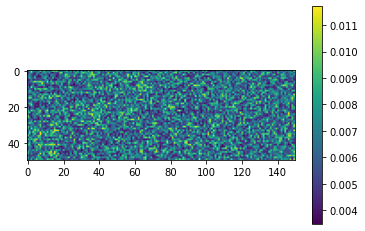

*6.907553672790527
******************************6.915876388549805
******************************6.892693519592285
******************************6.891327857971191
***6.8937201499938965
******************************6.899372577667236
******************************6.874241828918457
******************************6.873171806335449
**Finished Epoch 2. Loss at 6.894023418426514.


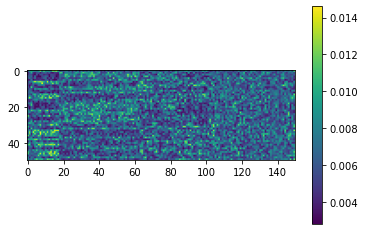

*6.878527641296387
******************************6.887720584869385
******************************6.851709842681885
******************************6.8562912940979
***6.863383769989014
******************************6.8725810050964355
******************************6.833084583282471
******************************6.839314937591553
**Finished Epoch 4. Loss at 6.864260673522949.


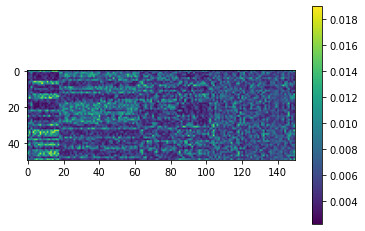

*6.84803581237793
******************************6.856210708618164
******************************6.8127665519714355
******************************6.8201141357421875
***6.832911968231201
******************************6.848167419433594
******************************6.79218864440918
******************************6.802651405334473
**Finished Epoch 6. Loss at 6.842792987823486.


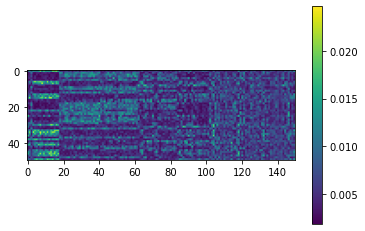

*6.815710067749023
******************************6.824991703033447
******************************6.770410060882568
******************************6.777098178863525
***6.803393363952637
******************************6.812437534332275
******************************6.758939266204834
******************************6.760339260101318
**Finished Epoch 8. Loss at 6.816731929779053.


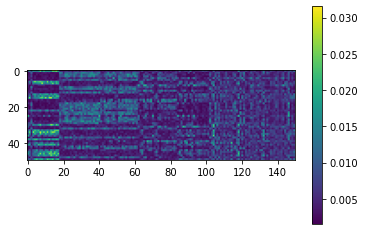

*6.783201694488525
******************************6.798853397369385
******************************6.731818675994873
******************************6.738527774810791
***6.76939058303833
******************************6.781783103942871
******************************6.717044353485107
******************************6.710558891296387
**Finished Epoch 10. Loss at 6.786577224731445.


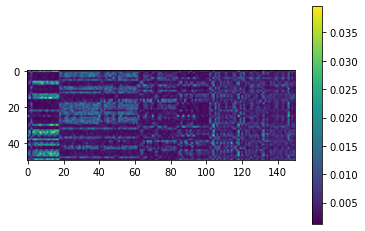

*6.74558687210083
******************************6.766280174255371
******************************6.696335792541504
******************************6.68633508682251
***6.716573238372803
******************************6.753179550170898
******************************6.673584938049316
******************************6.664316177368164
**Finished Epoch 12. Loss at 6.7523651123046875.


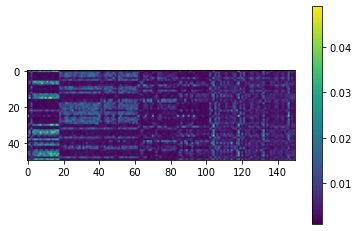

*6.691603183746338
******************************6.733931541442871
******************************6.644957065582275
******************************6.636820316314697
***6.672285556793213
******************************6.717562675476074
******************************6.629085540771484
******************************6.618627071380615
**Finished Epoch 14. Loss at 6.729224681854248.


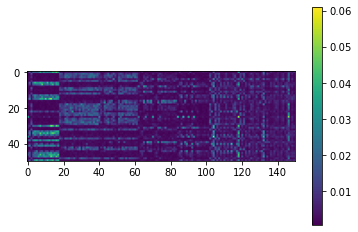

*6.648882865905762
******************************6.703498363494873
******************************6.597983360290527
******************************6.592092514038086
***6.627551555633545
******************************6.691081523895264
******************************6.558809757232666
******************************6.563363075256348
**Finished Epoch 16. Loss at 6.694093704223633.


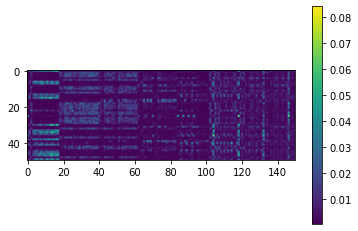

*6.590598106384277
******************************6.668901443481445
******************************6.529587268829346
******************************6.5306549072265625
***6.542444705963135
******************************6.64733362197876
******************************6.493642330169678
******************************6.48705530166626
**Finished Epoch 18. Loss at 6.66099739074707.


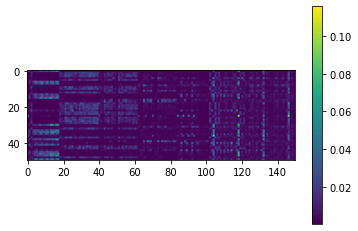

*6.481954574584961
******************************6.642435073852539
******************************6.451977252960205
******************************6.44253396987915
***6.408567428588867
******************************6.604662895202637
******************************6.404797077178955
******************************6.374318599700928
**Finished Epoch 20. Loss at 6.583842754364014.


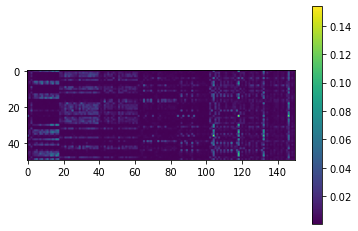

*6.328097820281982
******************************6.57116174697876
******************************6.325577259063721
******************************6.2862372398376465
***6.23589563369751
******************************6.522968769073486
******************************6.283254146575928
******************************6.195735931396484
**Finished Epoch 22. Loss at 6.420970439910889.


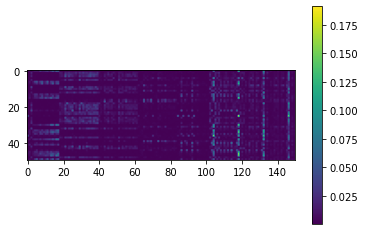

*6.215044021606445
******************************6.437117099761963
******************************6.229695796966553
******************************6.119589805603027
***6.1999192237854
******************************6.370112895965576
******************************6.198715686798096
******************************6.068506717681885
**Finished Epoch 24. Loss at 6.264650821685791.


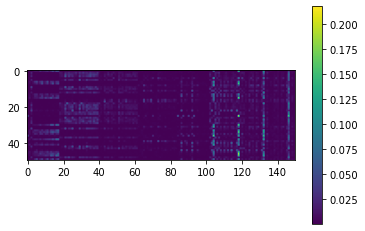

*6.2116522789001465
******************************6.3487229347229
******************************6.182600975036621
******************************6.039095878601074
***6.205827713012695
******************************6.330043792724609
******************************6.182608604431152
******************************6.023642539978027
**Finished Epoch 26. Loss at 6.194355487823486.


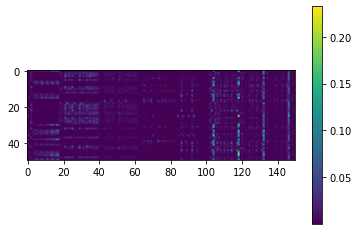

*6.204646587371826
******************************6.323815822601318
******************************6.182001113891602
******************************6.024574279785156
***6.206479549407959
******************************6.337252140045166
******************************6.154111862182617
******************************6.013987064361572
**Finished Epoch 28. Loss at 6.21445894241333.


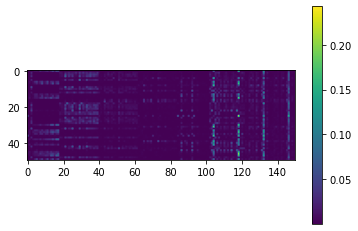

*6.201215744018555
******************************6.314871788024902
******************************6.148583889007568
******************************6.019012451171875
***6.196498394012451
******************************6.328129291534424
******************************6.12013053894043
******************************6.010047912597656
**Finished Epoch 30. Loss at 6.200461387634277.


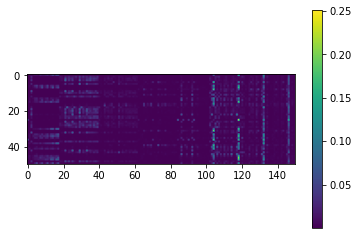

*6.199918746948242
******************************6.324851036071777
******************************6.147519588470459
******************************6.001994609832764
***6.198458194732666
******************************6.33510160446167
******************************6.1400604248046875
******************************5.99671745300293
**Finished Epoch 32. Loss at 6.178983211517334.


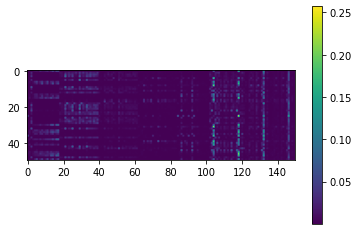

*6.20311164855957
******************************6.315469741821289
******************************6.1253862380981445
******************************6.007696628570557
***6.182247161865234
******************************6.309695720672607
******************************6.125161170959473
******************************5.994441986083984
**Finished Epoch 34. Loss at 6.1885294914245605.


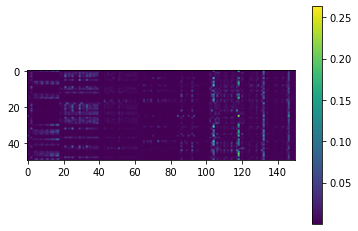

*6.174247741699219
******************************6.307805061340332
******************************6.118458271026611
******************************5.995845317840576
***6.183770656585693
******************************6.313940525054932
******************************6.119104862213135
******************************5.99100399017334
**Finished Epoch 36. Loss at 6.189209938049316.


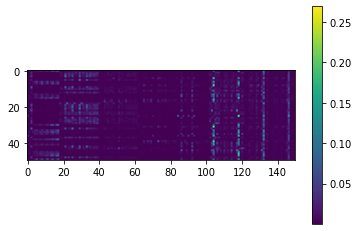

*6.189833641052246
******************************6.317971229553223
******************************6.110601902008057
******************************5.986984729766846
***6.163502216339111
******************************6.307122707366943
******************************6.112045764923096
******************************6.004623889923096
**Finished Epoch 38. Loss at 6.192875385284424.


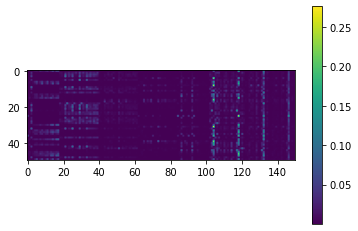

*6.18541145324707
******************************6.293673515319824
******************************6.1153106689453125
******************************5.993143081665039
**finished training
--- 330.41972064971924 seconds ---


In [11]:
loss_func = losses.GeneralizedLiftedStructureLoss()
training_loss = []
statnet_model.train() # Set model to training mode
optimizer.zero_grad()
statnet_model.zero_grad()
print('Starting Training:')
for i, epoch in enumerate(range(num_epochs)):
    for j, texture_batch in enumerate(dtd_dataloader):
        #grab texture batch and generate matching labels
        output = texture_batch[0].to(device)
        output = torch.flatten(output, start_dim=0, end_dim=1)
        
        current_batch_size = output.shape[0] // num_crops
        
        if current_batch_size < batch_size:
            continue  # Skip this batch if it's smaller than the usual batch size

        texture_labels = torch.repeat_interleave(torch.arange(batch_size),num_crops)
        #apply random permutation
        perm = torch.randperm(batch_size * num_crops)
        #print(perm)
        #print(output.shape)
        #print(batch_size * num_crops)
        output = output[perm]
        texture_labels = texture_labels[perm]

        #calculate stats
        #print(output.shape)
        stats_vector = statnet_model.forward(output) #statsvector torch.Size([200, 150])
        
        # synchronize before calculating the loss
        torch.cuda.synchronize()
        
        #loss definitions
        representation_loss = loss_func_contrastive(stats_vector, texture_labels)
        sparsity_loss = statnet_model.sparse_loss()
        loss = representation_loss + (sparsity_penalty * sparsity_loss) #+ norm_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        print('*',end='')
        #training_loss.append(loss.item())      
        if(j%30==0):
            print(loss.item())
        if(j==100):
            break;
            
        training_loss.append(loss.item())
        
    num_total_epochs = num_total_epochs + 1
    #print(f'Finished Epoch {i}. Loss at {loss}.')
    if(i%2==0):
        print(f'Finished Epoch {i}. Loss at {loss}.')
        compressor_mat = statnet_model.w.T.data.cpu().numpy()
        plt.imshow(compressor_mat)
        plt.colorbar() 
        plt.show()
torch.save(
        {'state_dict': statnet_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_loss':training_loss,
        'last_output':output,
        'last_statvec':stats_vector},
        f'./model_checkpoint_epoch_{i}.pth')
print('finished training')
print("--- %s seconds ---" % (time.time() - start_time))

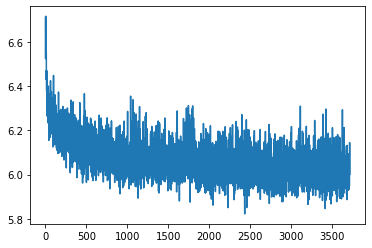

In [24]:
plt.plot(training_loss)

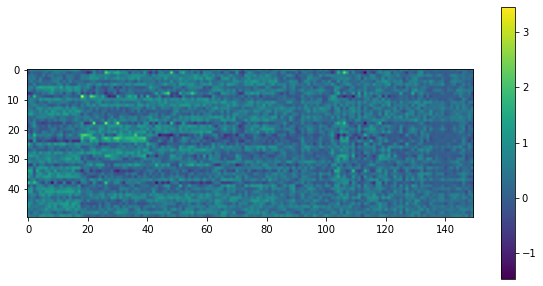

In [12]:

compressor_mat = statnet_model.w.T.data.cpu().numpy()
plt.figure(figsize=(10,5))
plt.imshow(compressor_mat)
plt.colorbar()


Most Important 25 Stats:
37.299927 phase_correlation 1 er (0, 3)
34.84387 skew 2
34.547596 phase_correlation 1 er (1, 3)
34.544716 edge_mean 1 3
33.129543 edge_stop 2 2
32.984802 skew 4
32.384876 edge_stop 2 3
32.095215 kurtosis 3
31.846376 edge_mean 1 2
31.317421 kurtosis 4
31.289692 edge_stop 1 0
31.236929 kurtosis 5
31.228804 edge_correlation 1 (0, 3)
30.858047 kurtosis 2
30.835186 variance
30.596935 edge_correlation (2, 3) 3
30.421957 phase_correlation (1, 2) er*di 2
30.33551 edge_mean 1 0
30.266336 skew 5
29.867847 mean
29.79852 edge_correlation 1 (1, 2)
29.556665 edge_mean 1 1
29.418007 edge_mean 2 2
29.335112 phase_correlation 2 er (0, 3)
29.2203 edge_variance 1 3


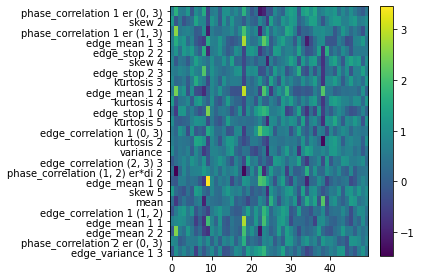

Least Important 25 Stats:
7.248062 phase_correlation (3, 4) ei*di 2
8.609997 phase_correlation (3, 4) er*di 2
10.557997 phase_correlation (3, 4) ei*di 0
10.716305 phase_correlation (3, 4) er*di 0
11.332661 phase_correlation (2, 3) ei*di 2
11.726465 phase_correlation 4 er (1, 2)
11.76642 edge_variance 4 2
11.862522 phase_correlation (3, 4) ei*di 1
12.619634 phase_correlation (2, 3) ei*di 0
12.6438465 phase_correlation (1, 2) ei*di 2
13.00638 phase_correlation (2, 3) ei*di 1
13.50493 phase_correlation (3, 4) ei*di 3
13.558426 edge_mean 4 2
13.58332 phase_correlation (1, 2) ei*di 1
14.168334 phase_correlation (2, 3) ei*di 3
14.825611 edge_correlation 4 (0, 2)
15.398488 edge_correlation 4 (1, 2)
15.456933 phase_correlation (3, 4) er*di 3
15.707692 edge_correlation (3, 4) 2
15.948408 edge_correlation 4 (1, 3)
16.202082 edge_correlation 4 (2, 3)
16.227463 phase_correlation 4 er (2, 3)
16.508413 phase_correlation 4 er (1, 3)
16.665995 edge_mean 4 1
16.97372 phase_correlation (3, 4) er*di 1


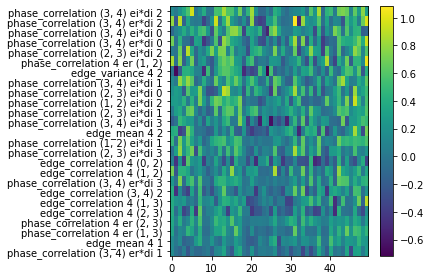

In [13]:
stat_sums = np.sum(np.abs(compressor_mat),axis=0) #how weighted is each of the 150 stats?
stat_index_array = np.argsort(stat_sums)[::-1] #get their importance order

ordered_stat_sums = stat_sums[stat_index_array]
ordered_stat_labels = np.array(stat_labels,dtype=object)[stat_index_array]
ordered_stats_labels_pretty = [' '.join([''.join(str(item)) for item in row if item not in ['',None]]) for row in ordered_stat_labels]

n=25
print(f'Most Important {n} Stats:')
for i in range(n):
    print(ordered_stat_sums[i],ordered_stats_labels_pretty[i])

#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)), labels=top_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    
    
#plot most important stats for contrastive learning
#plt.imshow(compressor_mat[:,stat_index_array[:n]].T)

print(f'Least Important {n} Stats:')
for i in range(1,n+1):
    print(ordered_stat_sums[-i],ordered_stats_labels_pretty[-i])
    
    
#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[-n:]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
bot_stats = ordered_stats_labels_pretty[-n:][::-1]
ax.set_yticks(np.arange(len(bot_stats)), labels=bot_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    

In [14]:
?list.insert

Signature: list.insert(self, index, object, /)
Docstring: Insert object before index.
Type:      method_descriptor


using cuda
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/95 [00:00<?, ?it/s]

fitting...


  0%|          | 0/10000 [00:00<?, ?it/s]

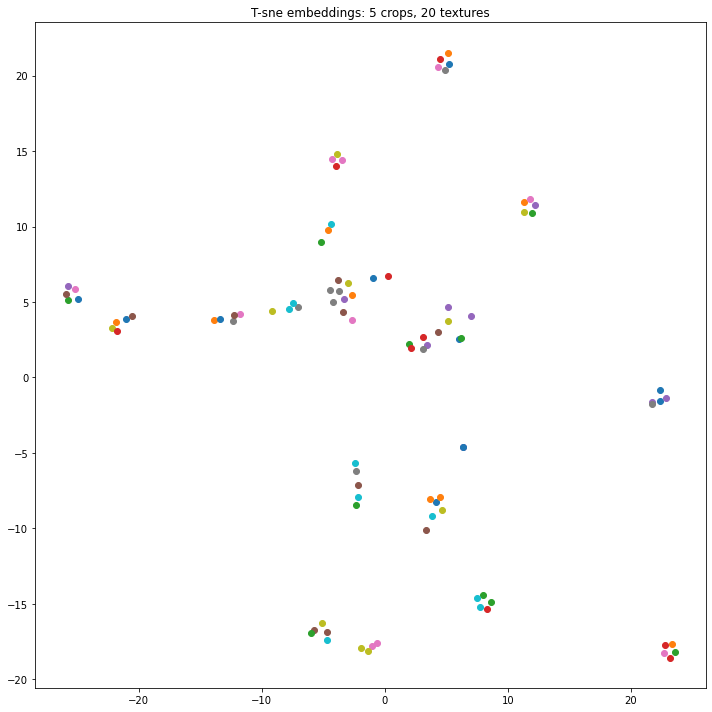

In [29]:
from tsne_torch import TorchTSNE as TSNE

# 1. Get model embeddings
stats_vector = statnet_model.forward(output)
X = stats_vector  # Assuming shape (n_samples, d)

# 2. Compute t-SNE embeddings
X_emb = TSNE(n_components=2, perplexity=8, n_iter=10000, verbose=True).fit_transform(X)

# 3. Adjust texture labels
texture_label = texture_labels[:-5]
texture_label_list = texture_label.numpy()

# 4. Get unique textures
unique_textures = set(texture_label_list)

# 5. Plot t-SNE embeddings
plt.figure(figsize=(10, 10))
for texture in unique_textures:
    texture_index = np.where(texture_label_list == texture)[0]
    plt.scatter(X_emb[texture_index, 0], X_emb[texture_index, 1], label=str(texture))

# Optional: If you have too many labels, the legend might become cluttered.
# If you have fewer labels, uncomment the next line.
# plt.legend(loc='upper right')

plt.title(f'T-sne embeddings: {num_crops} crops, {batch_size} textures')
plt.tight_layout()
plt.show()